# Implementation of ResNet-50 Model

In [1]:
import os
import sys
import time
import copy
from pathlib import Path

import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Global Vars
device = 'cpu'

path = '../../Datasets/ImageNet-Sketch/sketch'
custom_path = '../../Datasets/Custom'
class_paths = [f for f in Path(path).glob('*')]
image_paths = [f for f in Path(path).glob('*\*.JPEG')]
num_classes = len(class_paths)
dataset_total_size = len(image_paths)

image_size = 224
batch_size = 32
epochs = 1
feature_extract = True

print('PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('CUDA available')
    device='cuda'
else:
    print('WARNING: CUDA is not available')
    device='cpu'

print(os.getcwd())

PyTorch version: 1.10.1
CUDA available
c:\Users\Admin\Desktop\Tharja\Term 7\CV\50.039-CV-Project\Models\ResNet-50


In [3]:
print(f'# Classes: {num_classes}')
print(f'# Images: {dataset_total_size}')
print(class_paths[:10])

# Classes: 1000
# Images: 50889
[WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01440764'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01443537'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01484850'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01491361'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01494475'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01496331'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01498041'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514668'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514859'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01518878')]


In [4]:
# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)
print(classes[:10], {k: class_dict[k] for k in list(class_dict)[:10]})

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878'] {'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9}


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


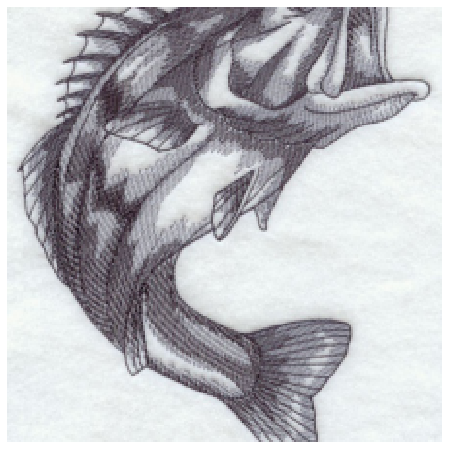

In [5]:
# Test loading in the data
idx = random.randint(0, 999)
transform = transforms.Compose([transforms.Resize(image_size+1),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor()])

full = datasets.ImageFolder(path, transform=transform)
full_dataloader = DataLoader(full, batch_size=batch_size, shuffle=False)

img, labels = next(iter(full_dataloader))

image = img[0].swapaxes(0,1)
image = image.swapaxes(1,2)

print(labels)

plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
# split dataset into train and test sets
train, test = torch.utils.data.random_split(full, [int(dataset_total_size * 0.8), dataset_total_size - int(dataset_total_size * 0.8)], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

# put datasets into a dictionary
dataloaders_dict = {'train': train_dataloader, 'test': test_dataloader}

In [7]:
# load validation dataset from the /Datasets/Custom

In [8]:
# define ResNet-50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(model, feature_extract)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
input_size = image_size

model = model.to(device)

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [11]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [12]:
# Train and Validate
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=epochs)

Epoch 0/0
----------
train Loss: 6.6027 Acc: 0.0394
test Loss: 6.1944 Acc: 0.1203

Training complete in 11m 59s
Best test Acc: 0.120259
